# Regressão Linear

O objetivo deste notebook é:

* introduzir os conceitos básicos iniciais de redes neurais através da 
* otimização de um ajuste de pontos por uma reta (linear) utilizando a 
* técnica de cálculo numérico do gradiente descendente. 

É introduzido também:

* o uso de matrizes tanto como 
    * notação matemática como 
    * forma de programação. 

Este notebook contém:
* primeiros programas matriciais, 
* laço de otimização e 
* plotagem de gráficos.


## Importação dos módulos

O objetivo deste exercício é utilizar apenas as funções do NumPy para o processamento numérico. Iremos precisar entretanto de dois outros pacotes para:

* NumPy: Pacote Numérico do Python - é o que faz o Python ser melhor que o MATLAB
* matplotlib: ferramentas para plotagem de gráficos e imagens
* sklearn: Excelente pacote de "Aprendizagem de Máquina", aqui será usado apenas para carregar o dataset Iris

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numétrica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais.

## Conjunto de dados: Flôres Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](../figures/iris_petals_sepals.png)

## Dados: leitura e visualização

O carregamento dos dados é feito pelo comando do pacote sklearn: `load_iris`. Iremos utilizar apenas duas informações da variedade versicolor (classe 1): 

* X: comprimento das sépalas,
* Y: comprimento das pétalas.

Imprimimos o *shape* dos *arrays* `X` e `Y`. O *shape* indica as dimensões do array. Neste caso, observe que possui apenas uma dimensão com 50 elementos cada. 

`X` e `Y` são portanto dois arrays unidimensionais com 50 elementos cada, que são o número de amostras da variedade versicolor.

Imprimimos também, a título ilustrativo estes dois vetores:

In [2]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

X = data[:,0]
Y = data[:,1]

print 'X.shape:',X.shape, X.dtype
print 'Y.shape:',Y.shape, Y.dtype

print 'X:', X
print 'Y:', Y

X.shape: (50,) float64
Y.shape: (50,) float64
X: [ 7.   6.4  6.9  5.5  6.5  5.7  6.3  4.9  6.6  5.2  5.   5.9  6.   6.1  5.6
  6.7  5.6  5.8  6.2  5.6  5.9  6.1  6.3  6.1  6.4  6.6  6.8  6.7  6.   5.7
  5.5  5.5  5.8  6.   5.4  6.   6.7  6.3  5.6  5.5  5.5  6.1  5.8  5.   5.6
  5.7  5.7  6.2  5.1  5.7]
Y: [ 4.7  4.5  4.9  4.   4.6  4.5  4.7  3.3  4.6  3.9  3.5  4.2  4.   4.7  3.6
  4.4  4.5  4.1  4.5  3.9  4.8  4.   4.9  4.7  4.3  4.4  4.8  5.   4.5  3.5
  3.8  3.7  3.9  5.1  4.5  4.5  4.7  4.4  4.1  4.   4.4  4.6  4.   3.3  4.2
  4.2  4.2  4.3  3.   4.1]


## Visualização dos dados `X` e `Y`

A visualização das amostras é feita com o matplotlib, neste caso utilizando o `scatter`:

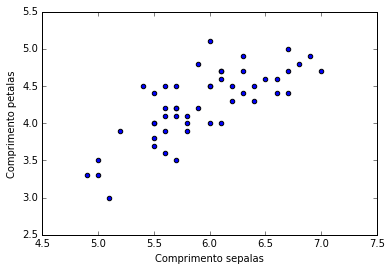

In [3]:
plt.scatter(X, Y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Estabilidade numérica

Em cálculo numérico trabalhamos com números representados em ponto flutuante com um número limitado de bits. Operações de valores muito grandes com valores muito baixos podem gerar resultados errados. Veja estes dois exemplos a seguir. No primeiro caso, faço uma soma acumulada começando de 1 de um pequeno valor `dx`. No segundo caso, faço uma soma acumulada começando de 1e10 do mesmo pequeno valor `dx`. No final, subtraio o valor acumulado pelo laço para que o resultado dê zero nos dois casos. Veja que no segundo caso, o erro é quase 1.


In [4]:
dx = 1e-6
n = 1000000

# Primeiro caso, somo pequeno valor a 1
x = 1.
for i in range(n):
    x = x + dx
print 'Erro:', x - 2.

# Segundo caso, somo pequeno valor a 1e10
x = 1e10
for i in range(n):
    x = x + dx
print 'Erro:', x - (1+1e10)


Erro: -8.22666379463e-11
Erro: 0.907348632812


### Normalização dos dados entre 0 e 1

A equação da normalização dos dados para que o resultado fique entre 0 e 1 é:

$$ y = \frac{x - x_{min}}{x_{max}-x_{min}} $$

Uma forma usual sequencial de fazer esta operação de forma um pouco mais eficiente é:

$$ xx = x - x_{min} \\
   y = \frac{xx}{xx_{max}} $$

Desta forma é usual implementar a normalização através de uma subtração *in place* do mínimo e depois uma divisão também *in place* pelo máximo:

In [5]:
X -= X.min()
X /= X.max()    # normalização
Y -= Y.min()
Y /= Y.max()

#Y = 2*X        # útil para verificar se o programa está funcionando (como exercício)

## Visualização dos dados normalizados


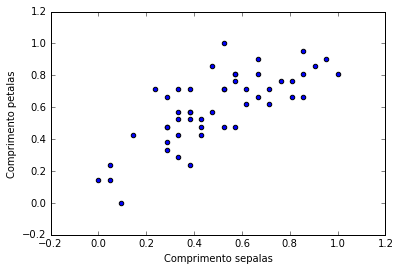

In [6]:
plt.scatter(X, Y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:

![](../figures/linhareta.png)

A reta de ajuste será dada por:

$$ y = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $y$ é a predição (comprimento estimado das pétalas).

### Programação Matricial

Como iremos trabalhar com várias amostras, dezenas, centenas, milhares, centenas de milhares, é mais eficiente trabalhar com vetores, matrizes e *arrays* por ser uma forma muito mais eficiente de se programar e de se processar. 

Talvez essa seja uma das **principais dificuldades** de programadores de linguagens "estilo C" onde é usual o uso de laços explícitos nos cálculos. 

Neste curso iremos usar intensivamente o NumPy que é o pacote de *arrays* numéricos que permitem programação matricial de forma muito eficiente.

### Representação matricial da equação linear

Supondo que temos $n$ amostras, as equações para todas as amostram ficam:

$$ \begin{bmatrix}
y_0\\ 
y_1\\
\\
y_{n-1}  \end{bmatrix} = \begin{bmatrix}
w_0 &+& x_0 w_1\\ 
w_0 &+& x_1 w_1\\
\\ 
w_0 &+& x_{n-1} w_1\\ 
\end{bmatrix} $$

Para facilitar a conversão matricial dos dois parâmetros da reta: $ w_0$ e $w_1 $, é usual fazer as seguintes transformações:

$$ \begin{bmatrix}
y_0\\ 
y_1\\
\\
y_{n-1}  \end{bmatrix} = \begin{bmatrix}
1\ w_0&+&x_0 w_1\\ 
1\ w_0&+&x_1 w_1\\
\\ 
1\ w_0&+&x_{n-1}  w_1\\ 
\end{bmatrix} $$

que é equivalente à operação matricial:

$$ \begin{bmatrix}
y_0\\ 
y_1\\
\\
y_{n-1} 
\end{bmatrix} = \begin{bmatrix}
1 & x_0 \\ 
1 & x_1\\
\\ 
1 & x_{n-1} \\ 
\end{bmatrix}\begin{bmatrix}
w_0\\ 
w_1
\end{bmatrix} $$

Em notação matricial:

$$ \boldsymbol{Y} = \boldsymbol{X} \boldsymbol{W} $$.

A multiplicação de matrizes é implementada em Python/Numpy usando o operador `dot`. 
Temos duas notações principais:  
* `X.dot(W)` ou 
* `np.dot(X,W)`. 

As matrizes são caracterizadas pelas suas dimensões que no NumPy são denominados
* `shape` que para matrizes é organizado em 
* `(linhas, colunas)`. 

Na multiplicação $\boldsymbol{X} \boldsymbol{W}$, 
* `X.shape=(n,2)` e 
* `W.shape=(2,1)`, cujo resultado da multiplicação será 
* `(n,2)(2,1)->(n,1)` que é shape de $\boldsymbol{Y}$.

**Dica:** Operações matriciais tornam o código conciso, poderoso e simples, porém, é comum aparecer erros nestas operações e uma das melhores formas de verificar isso é imprimindo o shape das
matrizes em uso.

### Aumento da dimensionalidade do problema

Uma das principais vantagens da representação matricial acima é a facilidade de aumento da
dimensionalidade do problema, sem mudança da equação matricial e consequentemente sem
mudança do código do programa. 

Se no problema da estimativa da largura da pétula, quisermos
utilizar não apenas uma variável de entrada, mas **três**, as únicas modificações necessárias são
mudar as matrizes $\boldsymbol{X}$ e $\boldsymbol{W}$:

$$\begin{bmatrix}
y_0\\ 
y_1\\
\\
y_{n-1}
\end{bmatrix} = \begin{bmatrix}
1 & x_{0,1} & x_{0,2} & x_{0,3} \\ 
1 & x_{1,1} & x_{1,2} & x_{1,3}\\
\vdots & \vdots & \vdots\\ 
1 & x_{n-1,1} & x_{n-1,2} & x_{n-1,3} 
\end{bmatrix}\begin{bmatrix}
w_0\\ 
w_1 \\
w_2\\
w_3
\end{bmatrix}$$

Observe que agora as dimensões na multiplicação são: 
* `(n,1)=(n,4).dot(4,1)`.

## Formulação do problema do ajuste da reta como um problema de minimização

Dado um conjunto de pontos 
* $(x_i,y_i)$, queremos encontrar uma equação linear na
forma 
* $ \hat{y} = w_0 + w_1\ x $ de modo que o erro médio quadrático
* $ (y_i - \hat{y_i})^2 $ de todas as amostras $i$ seja mínimo. 

Isto é:

$$ J(w_0,w_1) = \frac{1}{2n} \sum_{i=0}^{n-1} (y_i - (w_0 + w_1\ x_i)^2 $$ seja mínimo.

Em notação matricial:

$$ J(W)=\frac{1}{2n}(XW−Y)^T(XW−Y) $$

A seguir é mostrado uma implementação matricial desta função:



In [7]:
def compute_cost(X, Y, W):
    '''
    Compute cost for linear regression
    '''
    n = Y.size  # número de amostras
    E = X.dot(W) - Y
    J = (E.T).dot(E)/ (2. * n)
    return J

O problema então se resume em encontrar os coeficientes de $\boldsymbol{W}$ que minimizem $J(\boldsymbol{W})$. Existem várias formas de se realizar esta otimização. Para fazer uma analogia com as redes neurais, a otimização será obtiva por método de cálculo numérico
conhecido como "gradiente descendente". Como o gradiente de uma função aponta sempre para os valores mais altos da função, o método do gradiente descendente consiste em atualizar o valor de $\boldsymbol{W}$ subtraindo-o proporcionalmente do gradiente, isto é, indo na direção contrária do gradiente na expectativa de que iremos encontrar valores menores.

Na equação da atualização do $\boldsymbol{W}$ a seguir, o fator $\eta$ é denominado *learning rate*. Ele é um parâmetro de ajuste fundamental para o sucesso da otimização: 

$$ \boldsymbol{W} = \boldsymbol{W} − \eta \Delta J(\boldsymbol{W}) $$

Desta forma então, calculando-se o gradiente de $J(\boldsymbol{W})$ e substituindo na equação acima temos:

$$ \boldsymbol{W} = \boldsymbol{W} − \eta \frac{1}{n}(X^T(XW−Y)) $$

Esta equação é implementada dentro da função `gradient_descent`.


In [8]:
def gradient_descent(X, Y, eta, num_iters):
    '''
    Perform gradient descent to learn W
    by taking num_items gradient steps with learning
    rate eta
    '''
    n = Y.size
    W = np.zeros(shape=(2, 1))
    J_history = np.zeros(shape=(num_iters, ))
    W_history = np.zeros(shape=(2,num_iters))

    for i in range(num_iters):
        errors = (X.T).dot(X.dot(W) - Y)
        W = W - eta * (1.0 / n) * errors
    
        W_history[:,i] = W[:,0]
        J_history[i] = compute_cost(X, Y, W)
    return W, J_history, W_history

O esquema da otimização é representado pelo diagrama a seguir:

![](../figures/gradientDescentDiagram.png)

e é implementado pela próxima célula de código:

## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\boldsymbol{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.


X_bias.shape: (50, 2)
CPU times: user 14.1 ms, sys: 51.8 ms, total: 66 ms
Wall time: 24.1 ms
final cost: [[ 0.01063471]]
W_optimal:
[[ 0.28251264]
 [ 0.64557935]]


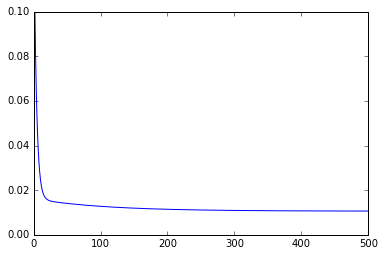

In [9]:
# Parâmetros do gradiente descendente: número de iterações e taxa de aprendizagem
iterations = 500
eta = 0.1

n = Y.size

#Montagem da matriz X agora com os elementos 1 na primeira coluna
X_bias = np.hstack([np.ones(shape=(n, 1)), X.reshape(-1,1)])
print 'X_bias.shape:',X_bias.shape

# ATENÇÃO: esta reformatação do Y para ser duas dimensões (n,1) é fundamental
# pois todas as equações assumem que as matrizes são todas bidimensionais
Y_matrix = Y.reshape(n,1) 


%time W_optimal, J_history, W_history = gradient_descent(X_bias, Y_matrix, eta, iterations)

print 'final cost:', compute_cost(X_bias, Y_matrix, W_optimal)
print 'W_optimal:\n', W_optimal

# Plot da curva de minimização de J com o número de iterações
plt.plot(J_history[:]) # mostrando log para amplificar valores baixos
plt.ylim(0,0.1)
plt.show()



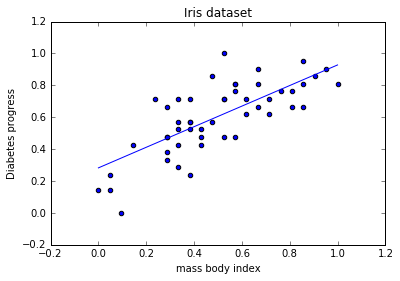

In [10]:
# Plotagem dos pontos
plt.scatter(X, Y, marker='o', c='b')
plt.title('Iris dataset')
plt.xlabel('mass body index')
plt.ylabel('Diabetes progress')

# Plotagem da reta utilizando os parâmetros ótimos encontrados no gradiente descendente

x = np.linspace(X.min(),X.max(),100).reshape(-1,1)
x_bias = np.hstack([np.ones_like(x),x])
result = x_bias.dot(W_optimal)  # Predição - utilizando a equação da reta
plt.plot(x, result)
plt.show()

## Visualização do espaço de parâmetros

Como o problema de ajuste de uma reta em pontos bidimensionais precisam da sintonia ou treinamento ou otimização de apenas dois parâmetros: $w_0$ e $w_1$, é possível visualizar o espaço de parâmetros em um gráfico. O trecho a seguir calcula o custo $J(\boldsymbol{W})$ a ser minimizado. Neste caso, a função $J$ é uma função convexa e possui apenas um único mínimo que será buscado pela técnica do gradiente descendente. O objetivo do gráfico a seguir é poder visualizar a convergência dos parâmetros $\boldsymbol{W}$ durante o processo de treinamento.

No código abaixo, primeiro é preciso calcular todos os possível $\boldsymbol{W}$ e para eles calcular a função $J(\boldsymbol{W})$. Isto é feito de forma matricial, sem a necessidade
de laços explícitos.

Wmin: [-0.32814074 -0.57825055]
Wmax: [ 0.83628148  1.25749431]
J.shape: (10000,)
W_history.shape: (2, 500)


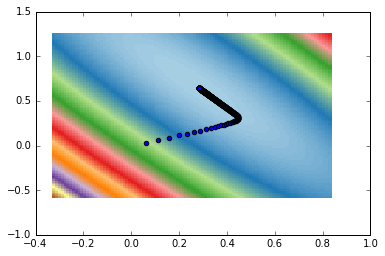

In [11]:
# Cálculo dos limites para gerar o espaço de parâmetros

Wmin = W_history.min(axis=1)
Wmax = W_history.max(axis=1)
D = Wmax - Wmin
Wmin -= D
Wmax += D
print 'Wmin:', Wmin
print 'Wmax:', Wmax

# Cálculo da matriz bidimensional de parâmetros
xx, yy = np.meshgrid(np.linspace(Wmin[0], Wmax[0],100), np.linspace(Wmin[1], Wmax[1],100))
W_grid = np.c_[xx.ravel(), yy.ravel()].T
#print xx.shape
#print W_grid.shape
#print X_bias.shape

# Cálculo do J(W) para todos os W da matriz de parâmetros

n = Y_matrix.size
E = ((X_bias.dot(W_grid) - Y_matrix)**2).sum(axis=0)
J = E/(2. * n)
print 'J.shape:', J.shape
print 'W_history.shape:', W_history.shape

# Plotagem de J na matriz de parâmetros
J = J.reshape(xx.shape)
plt.pcolormesh(xx, yy, J,cmap=plt.cm.Paired)

# Plotagem dos pontos da sequência dos parâmetros durante o processo do gradiente descendente

plt.scatter(W_history[0],W_history[1])
plt.show()



## Visualização da Perda x Parâmetros w0,w1 em gráfico 3D

A trecho a seguir permite a visualização da imagem anterior, agora numa superfície tridimensional de modo que para cada par de parâmetro $(w_0,w_1)$ o valor da perda $J(W)$ é uma altura da superfície no gráfico.
Sobre esta superfície da função Perda, os valores de $W$ ocorridos durante a busca do
gradiente descendente é mostrado na forma de bolinhas vermelhas. Desta forma é possível acompanhar o caminho que a solução percorre até chegar à solução ótima.

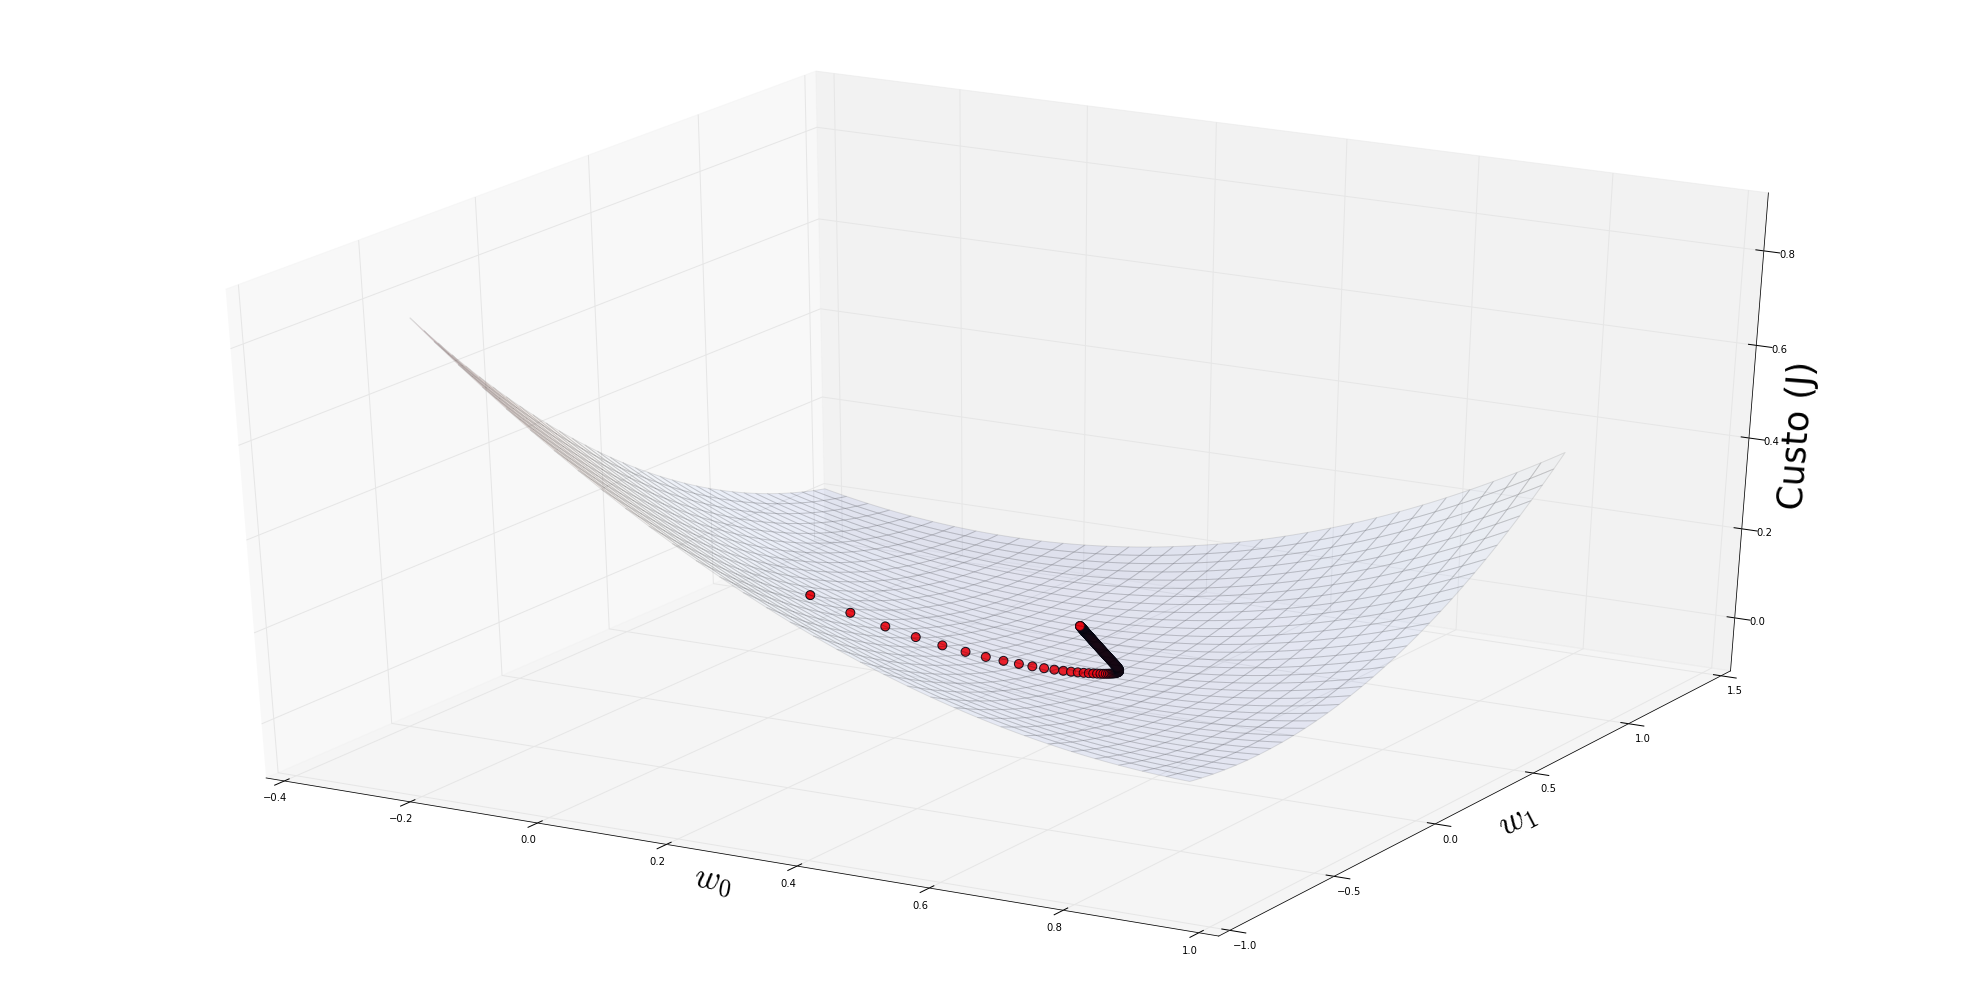

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


fig = plt.figure(figsize=(35,17.75))
ax = fig.add_subplot(111, projection='3d')

#plota a superfcie 3D
ax.plot_surface(xx, yy, J, rstride=3, cstride=3,  alpha=0.1, cmap=cm.coolwarm)
#Plota o historicos do vetor W
ax.scatter(W_history[0],W_history[1],J_history,c='r',marker = 'o',s = 80)
ax.set_xlabel(r'$w_0$',fontsize = 35)
ax.set_ylabel(r'$w_1$',fontsize = 35)
ax.set_zlabel('Custo (J)',fontsize = 35)
#ax.view_init(30, 10)

## Sugestões de atividades

1. Experimente trocar o número de iterações para bem pouco, 10 iterações e vai aumentando aos poucos. Mostre a perda com o número de iterações. Se for necessário, troque o `ylim` do gráfico para melhor visualização da curva da perda.
2. Troque o valor de $Y$ para gerar as amostras de forma sintética como uma reta, por exemplo, `Y = 2*X`. Qual é o valor ótimo que deve ser encontrado. Veja o que acontece e se o valor converge para o valor ótimo.
3. Varie a taxa de aprendizagem e verifique qual é o valor máximo e mínimo que pode ser utilizado.
4. Retire a normalização que é feita logo após a leitura dos dados e verifique o que acontece.

## Conclusões desse experimento

Quais são as principais conclusões que podemos tirar deste experimento?



## Referências

- [An Introduction to Gradient Descent in Python by Till Bergamann](http://tillbergmann.com/blog/python-gradient-descent.html) Blog, Agosto 2015.
